In [ ]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set()
from google.colab import files
from google.colab import drive
from IPython.display import Image
import datetime
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
title_akas = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/title_akas.tsv", sep='\t')
title_basics = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/title_basics.tsv", sep='\t')
title_crew = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/title_crew.tsv", sep='\t')
title_principals = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/title_principals.tsv", sep='\t')
title_ratings = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/title_ratings.tsv", sep='\t')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# title_basics1 = title_basics[title_basics['titleType'].isin(['movie'])]
# title_akas1 = title_akas[(title_akas['region']=='US')]
# print(title_akas1.shape)
# titles = pd.merge(title_akas1, title_basics1, left_on='titleId', right_on='tconst')
# titles.drop(columns=['tconst'], inplace=True)
# titles.drop_duplicates(subset=['titleId'], inplace=True)
# print(titles.shape)
inflation_index = pd.read_excel("/content/drive/My Drive/Colab Notebooks/IMDBData/CPIAUCNS.xls", skiprows=10)
inflation_index['observation_year'] = inflation_index['observation_date'].dt.year
inflation_index["CPI_Multiplier"] = inflation_index['CPIAUCNS'].iloc[-1] / inflation_index['CPIAUCNS']
inflation_index.drop(columns = ['observation_date'], inplace=True)
inflation_index.drop_duplicates(subset=['observation_year'], inplace=True)

### 1.Inflation over the years
Inflation between 1900 and 1930's did not follow the expected curve. A rise in inflation is likely to mean a rise in the cost of raw materials, workers were likely to demand higher wages to cope with the higher cost of living. Movies shot and released during this time will have a sudden higher cost and budget. This was around the start of the golden age of Hollywood, when some of the best movies were released. This abnormality can be attriuted to the era of the great depression.

Text(0.5, 1.0, 'Inflation over the last century')

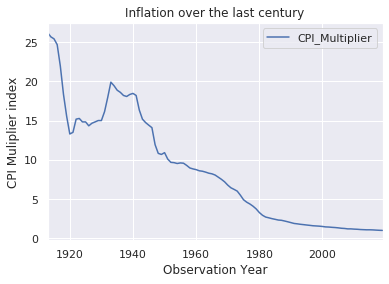

In [ ]:
inflation_mul_pivot = inflation_index.pivot_table(index="observation_year", values="CPI_Multiplier", aggfunc=np.median)
inflation_mul_pivot.plot()
plt.ylabel('CPI Muliplier index')
plt.xlabel('Observation Year')
plt.title('Inflation over the last century')

In [ ]:
raw_movie_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/movie_data.csv")
raw_movie_data = raw_movie_data.replace('\\N', np.nan)
raw_movie_data = raw_movie_data.replace('', np.nan)
for column in ['Budget', 'Cumulative Worldwide Gross', 'Gross USA']:
    raw_movie_data.loc[raw_movie_data[column].notnull(), column+'_Index'] = raw_movie_data[column].astype(str).str[0]

movie_data = raw_movie_data.copy()
movie_data = movie_data.loc[((movie_data['Budget'].isna()==True) | (movie_data['Budget_Index'].str.isdigit()==True)) &
                            ((movie_data['Cumulative Worldwide Gross'].isna()==True) |
                             (movie_data['Cumulative Worldwide Gross_Index'].str.isdigit()==True)) &
                            ((movie_data['Gross USA'].isna()==True) | (movie_data['Gross USA_Index'].str.isdigit()==True))]
print(movie_data.shape)

movie_data.loc[movie_data['Oscar Nominations'].isna()==True, "Oscar Nominations"] = 0
movie_data.loc[movie_data['Oscar Wins'].isna()==True, "Oscar Wins"] = 0
movie_data.loc[movie_data['Other Nominations'].isna()==True, "Other Nominations"] = 0
movie_data.loc[movie_data['Other Wins'].isna()==True, "Other Wins"] = 0
# print(movie_data.shape)
movie_data = pd.merge(movie_data, title_basics, left_on='titleId', right_on='tconst')
movie_data = pd.merge(movie_data, title_ratings, left_on='titleId', right_on='tconst')
# print(movie_data.shape)
title_akas1 = title_akas.drop_duplicates(subset=['titleId'])
movie_data = pd.merge(movie_data, title_akas1, left_on='titleId', right_on='titleId')

movie_data = movie_data.replace('\\N', np.nan)
movie_data = movie_data.replace('', np.nan)

movie_data['startYear'] = movie_data['startYear'].fillna(1950)
movie_data['startYear'] = movie_data['startYear'].astype('int')

print(movie_data.shape)
movie_data = pd.merge(movie_data, inflation_index, left_on='startYear', right_on='observation_year')
print(movie_data.shape)

for column in ['Budget', 'Cumulative Worldwide Gross', 'Gross USA', 'Opening Weekend USA']:
    movie_data[column + '_inflation_adjusted'] = movie_data.apply(lambda row: float(row[column])*row['CPI_Multiplier'] if (not pd.isna(row[column])) else np.nan, axis = 1) 
    movie_data.drop(columns=[column], inplace=True)

movie_data.drop(columns=['titleType', 'tconst_x', 'tconst_y', 'endYear', 'title', 'isOriginalTitle', 'attributes', 'types', 'Budget_Index', 'Cumulative Worldwide Gross_Index',
                         'language', 'region', 'ordering', 'isAdult', 'CPIAUCNS', 'CPI_Multiplier', 'observation_year', 'Gross USA_Index'], inplace=True)

movie_data['Popularity'] = movie_data['Popularity'].str.replace(',','')
movie_data['Popularity'] = movie_data['Popularity'].astype('float')

for column in ['Budget_inflation_adjusted', 'Cumulative Worldwide Gross_inflation_adjusted', 'Gross USA_inflation_adjusted']:
    movie_data[column] = movie_data[column].astype('float')
print(movie_data.shape)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(158627, 17)
(85814, 36)
(85722, 39)
(85722, 21)


### 2. Movies over time
Since IMDB was a recently developed site, all reviews and scores accurately depict only the present decades affliction towards all movies. The case of how old movies are percieved is particularly intersting as it tells us how people in the current decade view old movies. The marketing/promotions on the old movies do not influence the way they are percieved by the current generation. 

Text(0.5, 1.0, 'Movie rating over time')

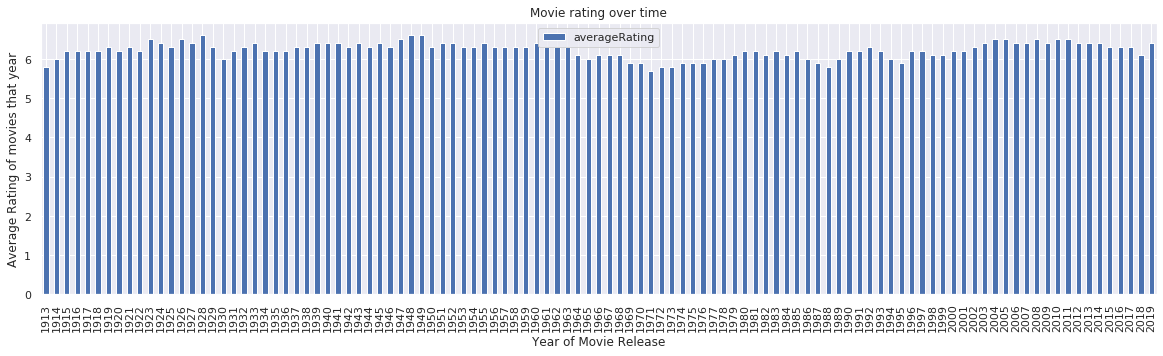

In [ ]:
rating_pivot = movie_data.pivot_table(index= "startYear",values="averageRating", aggfunc="median")  
rating_pivot.plot(kind="bar", figsize=(20,5))
plt.ylabel('Average Rating of movies that year')
plt.xlabel('Year of Movie Release')
plt.title('Movie rating over time')

It seems that our initial hypothesis was wrong. There is not much deviation on how people perceive movies over time. 


### 3. Movie Score Histogram

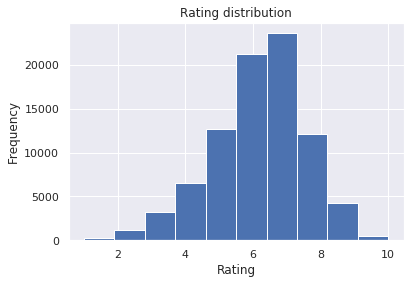

In [ ]:
plt.ylabel('Average Rating of movies that year')
plt.xlabel('Rating')
plt.title('Rating distribution')
movie_data.averageRating.plot(kind="hist")

The movie scores follow a normal distribution, with most movies scored between 6 and 8. Relating with the general concensus a movie with a score/rating of ~7 is considered good. A score between 8 and 9 seems to be given to movies whose popularity last a while. 

In [ ]:
# Sound Mix Filtering
sound_df = movie_data["Sound Mix"].str.split("@", expand=True)
sound_mix_values = dict()
for column in sound_df.columns:
    ls = list(sound_df[column])
    for i in ls:
        if i in sound_mix_values:
            sound_mix_values[i] += 1
        else:
            sound_mix_values[i] = 1
sound_columns = []
for key,value in sound_mix_values.items():
    if value > 2000 and (key not in [np.nan, None]):
        sound_columns.append(key)
for sound_col in sound_columns:
        movie_data["Sound Mix_" + sound_col] = movie_data.apply(lambda row: (1 if ((not pd.isna(row["Sound Mix"])) and (sound_col in row["Sound Mix"])) else 0), axis = 1) 
movie_data.drop(columns=["Sound Mix"], inplace=True)

# Genre Assignment 
genre_df = movie_data["genres"].str.split(",", expand=True)
genre_values = dict()
for column in genre_df.columns:
    ls = list(genre_df[column])
    for i in ls:
        if i in genre_values:
            genre_values[i] += 1
        else:
            genre_values[i] = 1
imp_genres = []
for key, value in genre_values.items():
    try:
        if value > 1800 and (key not in [np.nan, None, '\\N']):
            imp_genres.append(key)
    except:
        print(key, value)
for value in imp_genres:
    movie_data["genres_" + value] = movie_data.apply(lambda row: (1 if ((not pd.isna(row["genres"])) and (value in row["genres"])) else 0), axis = 1) 
movie_data.drop(columns=["genres"], inplace=True)


In [ ]:
class PreProcess:
    def __init__(self):
        from sklearn.impute import SimpleImputer
        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer
        from sklearn.preprocessing import OneHotEncoder
        self.simple_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.continuous_data_imputor = IterativeImputer(max_iter=40, random_state=0, verbose=2)
        self.one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.categorical_columns = []
        self.cat_columns_and_categories = dict()
    
    def fit_categorical_imputer(self, data, fit_and_transform):
        if fit_and_transform == True:
            data[self.categorical_columns] = self.simple_imp.fit_transform(data[self.categorical_columns])
        else:
            data[self.categorical_columns] = self.simple_imp.transform(data[self.categorical_columns])
        for column in self.categorical_columns:
            data[column] = data[column].astype('category')
        return data
        
    def construct_one_hot_encoder_fit_transform_data(self, data, fit_and_transform):
        data_index = data.index
        category_data = data.loc[:, self.categorical_columns].copy()
        data.drop(columns=self.categorical_columns, inplace=True)

        if fit_and_transform == True:
            category_data = self.one_hot_encoder.fit_transform(category_data)
        else:
            category_data = self.one_hot_encoder.transform(category_data)

        columns = self.one_hot_encoder.get_feature_names(self.categorical_columns)
        category_data = pd.DataFrame(category_data, index=data_index, columns=columns)
        data = data.join(category_data)

        return data
    
    def fit_iterative_imputer(self, data, fit_and_transform):
        data_columns = data.columns
        data_index = data.index
        if fit_and_transform == True:
            data = self.continuous_data_imputor.fit_transform(data)
        else:
            data = self.continuous_data_imputor.transform(data)

        dataframe = pd.DataFrame(data, index=data_index, columns=data_columns)

        return dataframe
    
    

In [ ]:
def pick_k_category_values_for_encoding(category_series_object, k, preprocess_object, evaluate_categories):
  if evaluate_categories is True:
    value_counts = category_series_object.value_counts()
    categories = list(value_counts.index[:k] if k else value_counts.index)
    categories.append('Not_in_selected_categories')
    preprocess_object.cat_columns_and_categories[category_series_object.name] = categories
  else:
    categories = preprocess_object.cat_columns_and_categories[category_series_object.name]
    
  category_series_object = category_series_object.cat.set_categories(categories)
  category_series_object = category_series_object.fillna('Not_in_selected_categories')
  return category_series_object

In [ ]:
def scale_data(data):
    data_max = np.abs(data).max(axis=0)
    data_max[data_max==0]=1
    data = data/data_max
    return data

In [ ]:
# Entire preprocessing of the data. Didn't impute Popularity column. Don't want to play around with it.
preprocess_object = PreProcess()
preprocess_object.categorical_columns = ['AspectRatio', 'Color']
for column in preprocess_object.categorical_columns:
    movie_data[column] = movie_data[column].astype('category')
# Only picking top 10 frequent aspect ratio values and putting other into Not_in_selected_categories and creating column for all of them.
movie_data['AspectRatio'] = pick_k_category_values_for_encoding(movie_data['AspectRatio'], 10, preprocess_object, evaluate_categories=True)
movie_data = preprocess_object.fit_categorical_imputer(movie_data, fit_and_transform=True)
movie_data = preprocess_object.construct_one_hot_encoder_fit_transform_data(movie_data, fit_and_transform=True)

movie_data_ids = movie_data.loc[:,['titleId', 'Popularity', 'primaryTitle', 'originalTitle']].copy()
movie_data_imp = movie_data.copy()
movie_data_imp.drop(columns=['titleId', 'Popularity', 'primaryTitle', 'originalTitle'], inplace=True)
movie_data_imp = preprocess_object.fit_iterative_imputer(movie_data_imp, fit_and_transform=True)
for column in ['Budget_inflation_adjusted', 'Cumulative Worldwide Gross_inflation_adjusted', 'Gross USA_inflation_adjusted',
               'Opening Weekend USA_inflation_adjusted']:
    movie_data_imp.loc[movie_data_imp[column]<0, column] = 0
movie_data_imp = movie_data_imp.join(movie_data_ids)  # Dataframe that'll be used further for work

[IterativeImputer] Completing matrix with shape (85722, 53)
[IterativeImputer] Ending imputation round 1/40, elapsed time 1.21
[IterativeImputer] Ending imputation round 2/40, elapsed time 2.37
[IterativeImputer] Ending imputation round 3/40, elapsed time 3.58
[IterativeImputer] Ending imputation round 4/40, elapsed time 4.78
[IterativeImputer] Ending imputation round 5/40, elapsed time 6.03
[IterativeImputer] Ending imputation round 6/40, elapsed time 7.21
[IterativeImputer] Ending imputation round 7/40, elapsed time 8.40
[IterativeImputer] Ending imputation round 8/40, elapsed time 9.68
[IterativeImputer] Ending imputation round 9/40, elapsed time 10.97
[IterativeImputer] Ending imputation round 10/40, elapsed time 12.37
[IterativeImputer] Ending imputation round 11/40, elapsed time 13.62
[IterativeImputer] Ending imputation round 12/40, elapsed time 14.69
[IterativeImputer] Ending imputation round 13/40, elapsed time 15.97
[IterativeImputer] Ending imputation round 14/40, elapsed ti

In [ ]:
movie_data_imp['Popularity'].fillna(movie_data_imp['Popularity'].max(), inplace=True)
movie_data_imp['Popularity'] = movie_data_imp['Popularity'].max() - movie_data_imp['Popularity']
movie_data_imp['Popularity'].describe()

count    85722.000000
mean       113.700275
std        608.584545
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4997.000000
Name: Popularity, dtype: float64

Text(0.5, 1.0, 'Average Rating of movies vs Popularity')

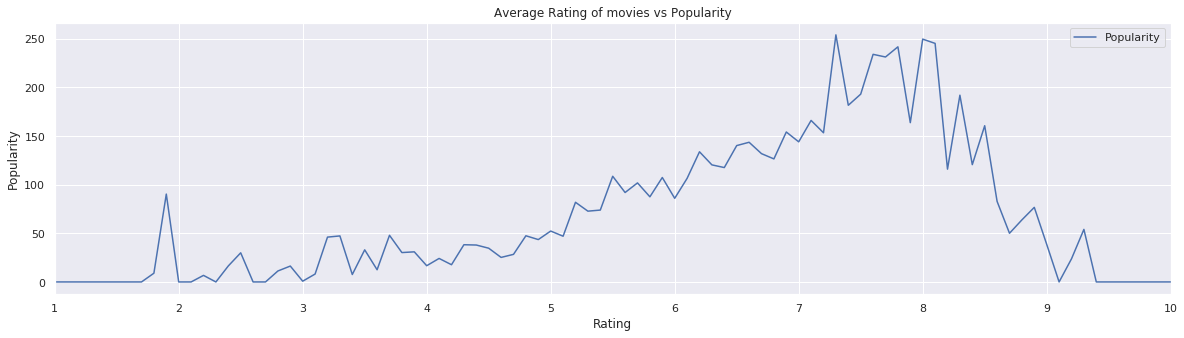

In [ ]:
popularity_rating_pivot = movie_data_imp.pivot_table(values="Popularity", index="averageRating", aggfunc="mean")
popularity_rating_pivot.plot( figsize=(20,5))
plt.ylabel('Popularity')
plt.xlabel('Rating')
plt.title('Average Rating of movies vs Popularity')

The rating of a movie dictates how popular it is. Movies in this dataset 



In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

features_considered = ['AspectRatio', 'Budget', 'Color', 'Cumulative Worldwide Gross', 'Gross USA', 'Metascore', 'Opening Weekend USA',
                       'Oscar Nominations', 'Oscar Wins', 'Other Nominations', 'Other Wins', 'Sound Mix', 'startYear',
                       'runtimeMinutes', 'genres', 'averageRating', 'numVotes']

consider_all_columns = list()
for feature in features_considered:         # Feature-wise Regression
    consider_columns = list()
    for column in movie_data_imp.columns:       # Considering only data where popularity is available
        if column.startswith(feature):
            consider_columns.append(column)
            consider_all_columns.append(column)

    X = scale(movie_data_imp[consider_columns])
    Y = scale(movie_data_imp['Popularity'])

    # Train tesh split of data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=5)

    # Fitting linear regression
    try:
        reg = LinearRegression().fit(X_train, y_train)
    except:
        print(feature)
    score = reg.score(X_test, y_test)
    print("Feature used for prediction: {} and the score: {}".format(feature, str(score)))

# All columns
X = scale(movie_data_imp[consider_all_columns])
Y = scale(movie_data_imp['Popularity'])

# Train tesh split of data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=5)

# Fitting linear regression
reg = LinearRegression().fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.1).fit(X_train, y_train)
score = reg.score(X_test, y_test)
lasso_score = lasso_reg.score(X_test, y_test)
print("All features used for prediction and the scores: {}, {}".format(str(score), str(lasso_score)))

Feature used for prediction: AspectRatio and the score: 0.20706980826173194
Feature used for prediction: Budget and the score: 0.2620584097975487
Feature used for prediction: Color and the score: 0.006192385210406659
Feature used for prediction: Cumulative Worldwide Gross and the score: 0.26580551805291475
Feature used for prediction: Gross USA and the score: 0.22112904754517548
Feature used for prediction: Metascore and the score: 0.002548453634761527
Feature used for prediction: Opening Weekend USA and the score: 0.28360332675902755
Feature used for prediction: Oscar Nominations and the score: 0.026583291167230794
Feature used for prediction: Oscar Wins and the score: 0.042979642159059576
Feature used for prediction: Other Nominations and the score: 0.22484423044151947
Feature used for prediction: Other Wins and the score: 0.13372696367931292
Feature used for prediction: Sound Mix and the score: 0.19444781691196267
Feature used for prediction: startYear and the score: 0.0130944349306

The short answer: network effects and positive feedback loops. Both concepts are described well by David Easley and Jon Kleinberg in their book “Networks, Crowds, and Markets: Reasoning about a Highly Connected World”¹⁰. In particular, they posit that popularity is a network phenomenon.

It’s easy to see how this might play out in our examples. In our networked world, people can recommend books, movies and games to each other. These titles will get more reviews, more shelf space, and ultimately, more attention.

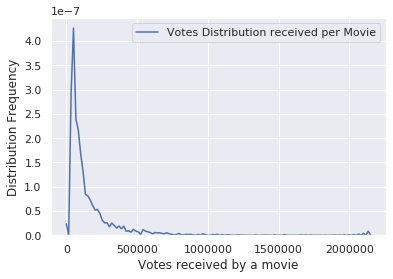

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


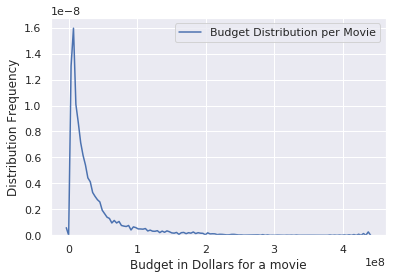

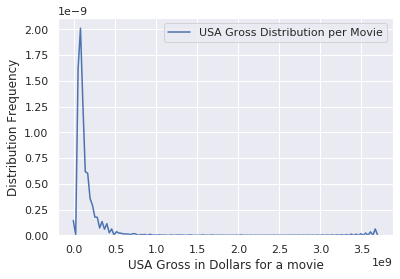

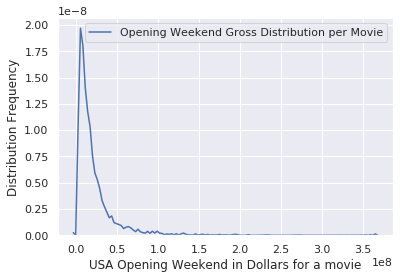

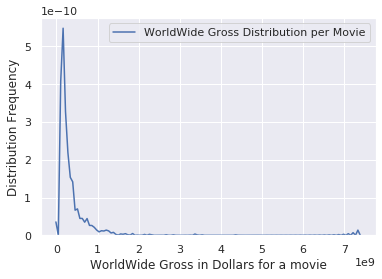

In [ ]:
sns.distplot(movie_data_imp['numVotes'], hist=False, label='Votes Distribution received per Movie')
plt.ylabel('Distribution Frequency')
plt.xlabel('Votes received by a movie')
plt.show()
sns.distplot(movie_data['Budget_inflation_adjusted'], hist=False, label='Budget Distribution per Movie')
plt.ylabel('Distribution Frequency')
plt.xlabel('Budget in Dollars for a movie')
plt.show()
sns.distplot(movie_data['Gross USA_inflation_adjusted'], hist=False, label='USA Gross Distribution per Movie')
plt.ylabel('Distribution Frequency')
plt.xlabel('USA Gross in Dollars for a movie')
plt.show()
sns.distplot(movie_data['Opening Weekend USA_inflation_adjusted'], hist=False, label='Opening Weekend Gross Distribution per Movie')
plt.ylabel('Distribution Frequency')
plt.xlabel('USA Opening Weekend in Dollars for a movie')
plt.show()
sns.distplot(movie_data['Cumulative Worldwide Gross_inflation_adjusted'], hist=False, label='WorldWide Gross Distribution per Movie')
plt.ylabel('Distribution Frequency')
plt.xlabel('WorldWide Gross in Dollars for a movie')
plt.show()

In [ ]:
movie_data_imp = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/preprocessed_movie_data.csv")

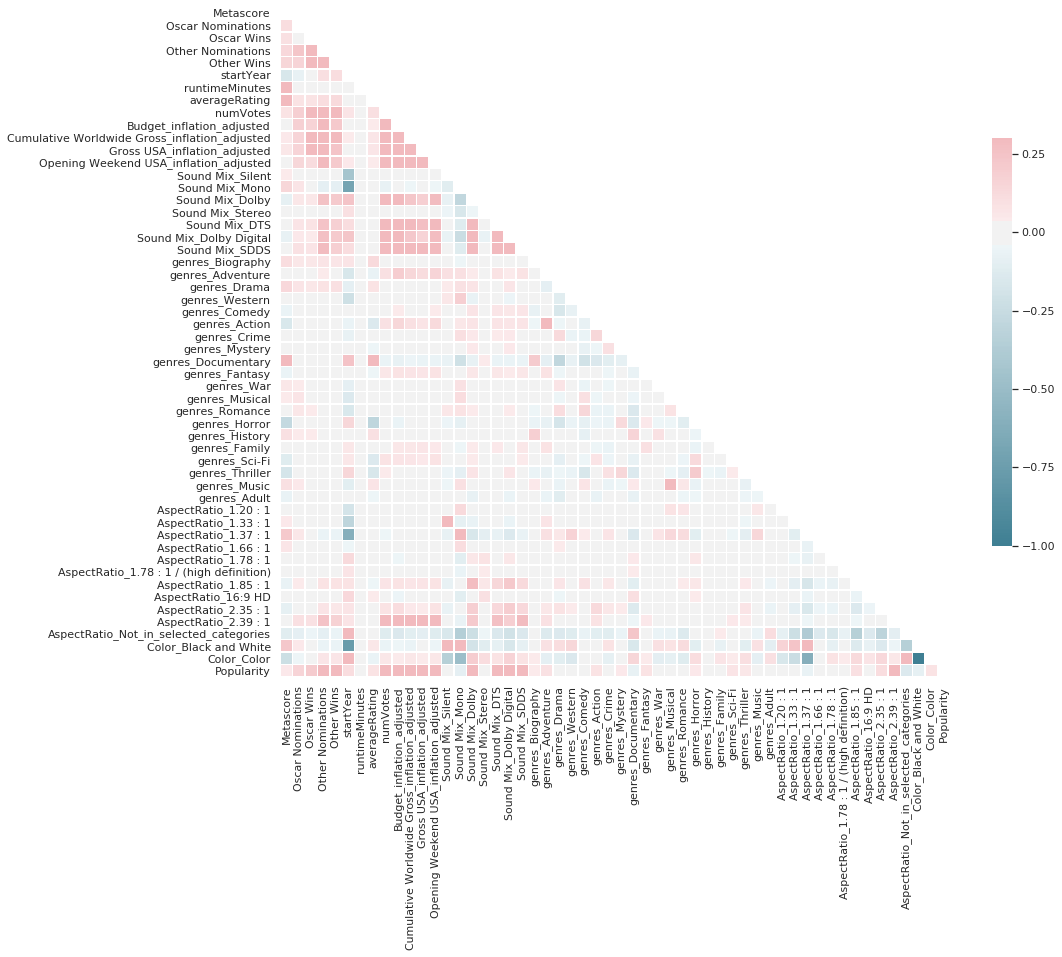

In [ ]:
corr = movie_data_imp[movie_data_imp.columns].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set(style='white')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
significant_corr = corr[corr>0.1]
significant_columns = list(significant_corr.index)
log_significant_columns = list(significant_corr.index)
for column in ['numVotes', 'Budget_inflation_adjusted', 'Cumulative Worldwide Gross_inflation_adjusted', 'Gross USA_inflation_adjusted',
               'Opening Weekend USA_inflation_adjusted']:
    log_significant_columns.remove(column)
    log_significant_columns.append('log_' + column)
    movie_data_imp[column] = movie_data_imp[column] + 10
    movie_data_imp['log_'+column] = movie_data_imp[column].apply(np.log)

In [ ]:
# from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist

corr_eval_df = movie_data_imp.loc[:, significant_columns]
index = corr_eval_df.index
columns = corr_eval_df.columns
corr_eval_df = scale_data(corr_eval_df)
corr_eval_df = pd.DataFrame(corr_eval_df, index=index, columns=columns)
processed_corr = corr_eval_df[corr_eval_df.columns].corr()['Popularity'][:]
print(processed_corr)
corr_eval_df['Model 1 Popularity Score'] = corr_eval_df.apply(lambda row: sum([processed_corr[sig_col]*row[sig_col] for sig_col in significant_columns]), axis = 1) 
corr_eval_df['titleId'] = movie_data_imp['titleId']
# data_distance = pdist(corr_eval_df['Popularity_Score'].to_numpy().reshape(-1,1), 'euclidean').reshape(-1,1)

# popularity_distance = pdist(corr_eval_df['Popularity'].to_numpy().reshape(-1,1), 'euclidean').reshape(-1,1)

# correlation_coeff = np.corrcoef(data_distance, popularity_distance, rowvar=False)
# print(correlation_coeff)

Metascore                                        0.048982
Oscar Nominations                                0.152971
Oscar Wins                                       0.200226
Other Nominations                                0.468061
Other Wins                                       0.354776
startYear                                        0.112856
runtimeMinutes                                   0.023146
averageRating                                    0.079518
numVotes                                         0.661108
Budget_inflation_adjusted                        0.514419
Cumulative Worldwide Gross_inflation_adjusted    0.506084
Gross USA_inflation_adjusted                     0.450985
Opening Weekend USA_inflation_adjusted           0.536319
Sound Mix_Silent                                -0.034765
Sound Mix_Mono                                  -0.095858
Sound Mix_Dolby                                  0.322284
Sound Mix_Stereo                                -0.000811
Sound Mix_DTS 

### 4. How well does the number of votes a movie receives correlate with its rating

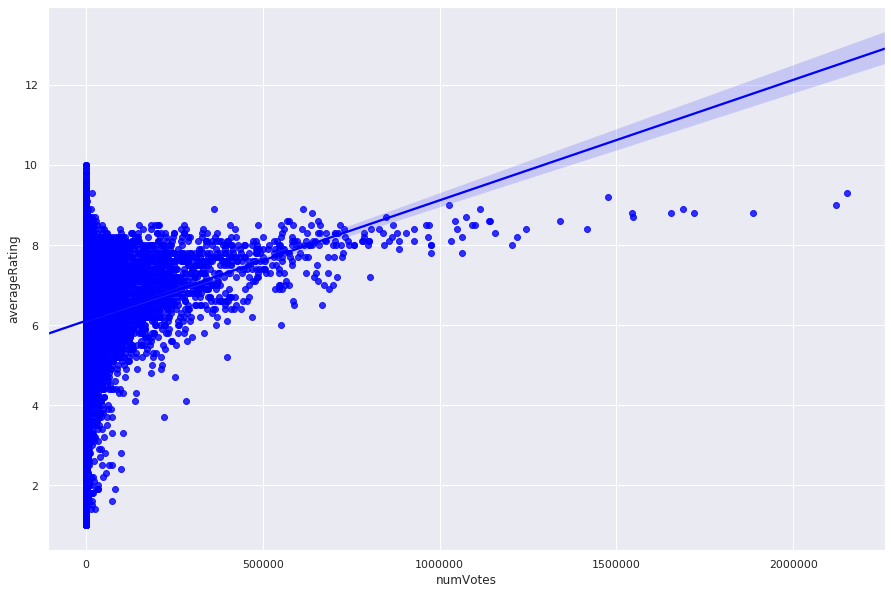

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.regplot(x = 'numVotes', y = 'averageRating', data = movie_data_imp, color = 'blue' )

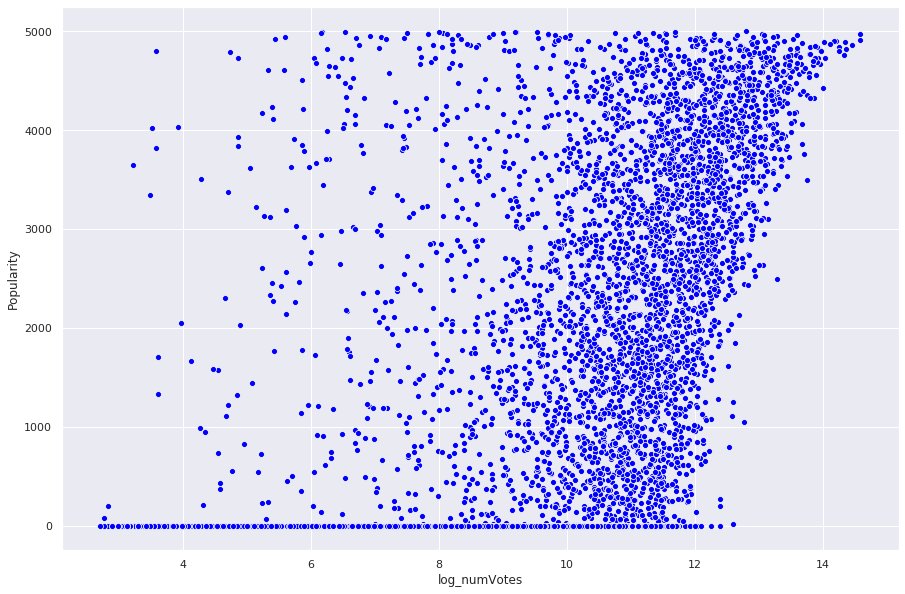

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x = 'log_numVotes', y = 'Popularity', data = movie_data_imp, color = 'blue' )

The above plot shows that the popularity of movies is highly corelated with the number of votes they receive. The percieved "liking" of a movie directly correlates with the number of votes it recieves. A highly popular movie will inturn have a lot of votes on its IMDb page.


In [ ]:
correlation_coeff = np.corrcoef(corr_eval_df['Model 1 Popularity Score'].to_numpy(), corr_eval_df['Popularity'].to_numpy(), rowvar=False)
print(correlation_coeff)

[[1.         0.67793346]
 [0.67793346 1.        ]]


In [ ]:
from sklearn.preprocessing import scale
log_corr_eval_df = movie_data_imp.loc[:, log_significant_columns]
index = log_corr_eval_df.index
columns = log_corr_eval_df.columns
log_corr_eval_df = scale(log_corr_eval_df)
log_corr_eval_df = pd.DataFrame(log_corr_eval_df, index=index, columns=columns)
log_processed_corr = log_corr_eval_df[log_corr_eval_df.columns].corr()['Popularity'][:]
# print(log_processed_corr)
log_corr_eval_df['Model 2 Popularity Score'] = log_corr_eval_df.apply(lambda row: sum([log_processed_corr[sig_col]*row[sig_col] for sig_col in log_significant_columns]), axis = 1) 
log_corr_eval_df['titleId'] = movie_data_imp['titleId']

In [ ]:
correlation_coeff = np.corrcoef(log_corr_eval_df['Model 2 Popularity Score'].to_numpy(), log_corr_eval_df['Popularity'].to_numpy(), rowvar=False)
print(correlation_coeff)

[[1.         0.78174369]
 [0.78174369 1.        ]]


In [ ]:
decade_wise_data = movie_data_imp.copy()
decade_wise_data['Decade'] = decade_wise_data['startYear'] - (decade_wise_data['startYear']%10)
decade_wise_data["Performance"] = movie_data.apply(lambda row: np.nan if (pd.isna(row['Budget_inflation_adjusted']) or pd.isna(row['Cumulative Worldwide Gross_inflation_adjusted']) or row['Budget_inflation_adjusted']==0) else row['Cumulative Worldwide Gross_inflation_adjusted'] - row['Budget_inflation_adjusted'], axis = 1) 
decade_wise_data.dropna(inplace=True)

consider_columns = ["Decade", "Performance", "titleId", "originalTitle"]

decade_wise_low_perf = decade_wise_data[consider_columns].sort_values('Performance', ascending=True).groupby(['Decade'], sort=False).head(5)
decade_wise_low_perf = decade_wise_low_perf.sort_values(by=['Decade'])
decade_wise_high_perf = decade_wise_data[consider_columns].sort_values('Performance', ascending=False).groupby(['Decade'], sort=False).head(5)
decade_wise_high_perf = decade_wise_high_perf.sort_values(by=['Decade'])

In [ ]:
decade_wise_low_perf = pd.merge(decade_wise_low_perf, corr_eval_df, left_on='titleId', right_on='titleId')
decade_wise_low_perf = pd.merge(decade_wise_low_perf, log_corr_eval_df, left_on='titleId', right_on='titleId')

decade_wise_high_perf = pd.merge(decade_wise_high_perf, corr_eval_df, left_on='titleId', right_on='titleId')
decade_wise_high_perf = pd.merge(decade_wise_high_perf, log_corr_eval_df, left_on='titleId', right_on='titleId')

consider_columns = ["Decade", "Performance", "titleId", "originalTitle", "Model 2 Popularity Score", "Model 1 Popularity Score"]
decade_wise_low_perf = decade_wise_low_perf[consider_columns]
decade_wise_high_perf = decade_wise_high_perf[consider_columns]

decade_wise_low_perf['Performance Type'] = "Worst Performed Movies"
decade_wise_high_perf['Performance Type'] = "Best Performed Movies"

movie_perf = pd.concat([decade_wise_low_perf, decade_wise_high_perf])

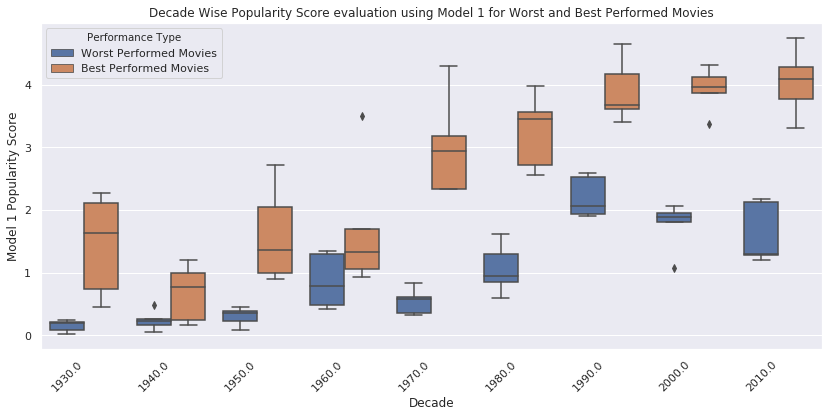

In [ ]:
plt.figure(figsize=(14, 6))
box_plot = sns.boxplot(data=movie_perf.loc[(movie_perf['Decade']>1920)], x='Decade', y='Model 1 Popularity Score', hue='Performance Type')
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Decade Wise Popularity Score evaluation using Model 1 for Worst and Best Performed Movies')
plt.show()

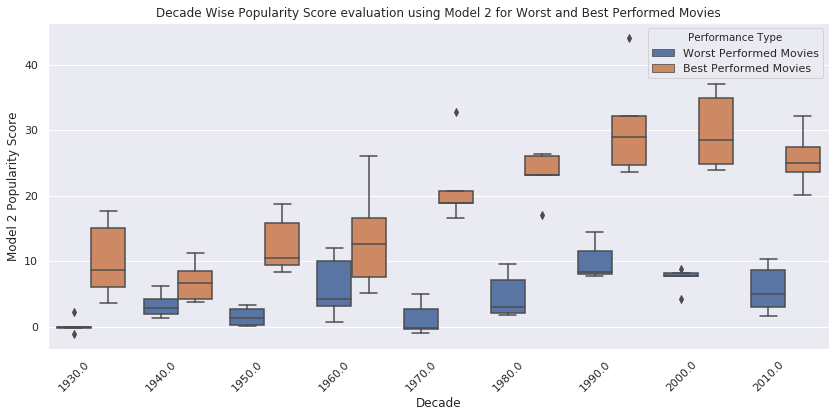

In [ ]:
plt.figure(figsize=(14, 6))
box_plot = sns.boxplot(data=movie_perf.loc[(movie_perf['Decade']>1920)], x='Decade', y='Model 2 Popularity Score', hue='Performance Type')
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Decade Wise Popularity Score evaluation using Model 2 for Worst and Best Performed Movies')
plt.show()

In [ ]:
rotten_tomatoes_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/IMDBData/RottenTomatoes_Top100.csv")

In [ ]:
corr_eval_df['top100'] = 0
log_corr_eval_df['top100'] = 0
corr_eval_df.loc[corr_eval_df['titleId'].isin(rotten_tomatoes_df['RottenTomatoes_to_IMDB_Mapped_ID']), 'top100'] = 1
log_corr_eval_df.loc[log_corr_eval_df['titleId'].isin(rotten_tomatoes_df['RottenTomatoes_to_IMDB_Mapped_ID']), 'top100'] = 1

In [ ]:
corr_eval_df.sort_values("Model 1 Popularity Score", inplace = True, ascending=False) 
corr_eval_df.index = np.arange(1,len(corr_eval_df)+1)
corr_eval_df['Rank'] = corr_eval_df.index

In [ ]:
corr_eval_df[corr_eval_df['top100']==1]['Rank'].describe()

count       89.000000
mean     11545.539326
std      19917.075015
min          1.000000
25%        320.000000
50%       1696.000000
75%      12798.000000
max      75201.000000
Name: Rank, dtype: float64

In [ ]:
log_corr_eval_df.sort_values("Model 2 Popularity Score", inplace = True, ascending=False) 
log_corr_eval_df.index = np.arange(1,len(log_corr_eval_df)+1)
log_corr_eval_df['Rank'] = log_corr_eval_df.index
log_corr_eval_df[log_corr_eval_df['top100']==1]['Rank'].describe()

count       89.000000
mean      2471.067416
std       3508.329089
min          1.000000
25%         92.000000
50%        627.000000
75%       3986.000000
max      15332.000000
Name: Rank, dtype: float64

In [ ]:
log_corr_eval_df[log_corr_eval_df['top100']==1]['Rank'].describe()

count       89.000000
mean      2471.067416
std       3508.329089
min          1.000000
25%         92.000000
50%        627.000000
75%       3986.000000
max      15332.000000
Name: Rank, dtype: float64

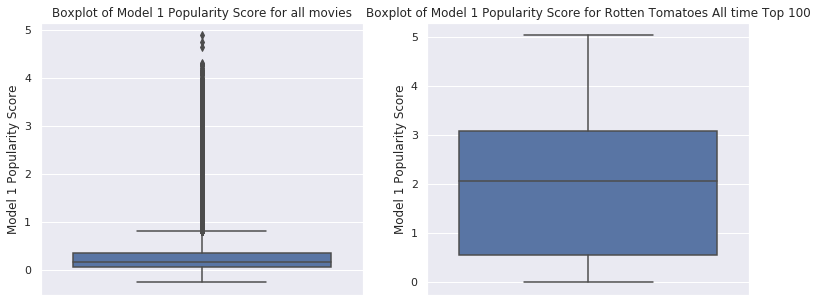

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.7, 5))
sns.boxplot(data=corr_eval_df.loc[corr_eval_df['top100']==0], y='Model 1 Popularity Score', ax=ax1)
sns.boxplot(data=corr_eval_df.loc[corr_eval_df['top100']==1], y='Model 1 Popularity Score', ax=ax2)
ax1.set_title('Boxplot of Model 1 Popularity Score for all movies')
ax2.set_title('Boxplot of Model 1 Popularity Score for Rotten Tomatoes All time Top 100')

fig.show()

In [ ]:
print(corr_eval_df.loc[corr_eval_df['top100']==0]['Model 1 Popularity Score'].describe())
print(corr_eval_df.loc[corr_eval_df['top100']==1]['Model 1 Popularity Score'].describe())

count    85633.000000
mean         0.317303
std          0.490545
min         -0.267080
25%          0.061489
50%          0.158644
75%          0.357575
max          4.889412
Name: Model 1 Popularity Score, dtype: float64
count    89.000000
mean      1.952567
std       1.354361
min      -0.005824
25%       0.555333
50%       2.052338
75%       3.082622
max       5.032012
Name: Model 1 Popularity Score, dtype: float64


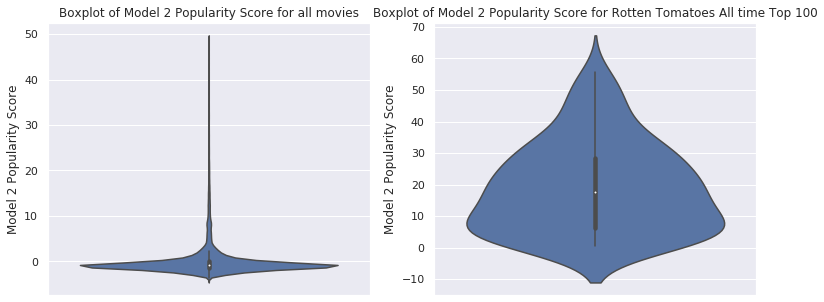

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.7, 5))
sns.violinplot(data=log_corr_eval_df.loc[log_corr_eval_df['top100']==0], y='Model 2 Popularity Score', ax=ax1)
sns.violinplot(data=log_corr_eval_df.loc[log_corr_eval_df['top100']==1], y='Model 2 Popularity Score', ax=ax2)
ax1.set_title('Boxplot of Model 2 Popularity Score for all movies')
ax2.set_title('Boxplot of Model 2 Popularity Score for Rotten Tomatoes All time Top 100')
fig.show()